## Pass rate

In [1]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

Import and explore data

In [4]:
#reference redacted#

In [122]:
#fsr.describe() redacted

In [123]:
#dr.describe() redacted

In [7]:
fsr_merge = fsr[['user_id','face_comparison_result','facial_image_integrity_result',]]

In [8]:
dr_merge = dr.copy(deep = True)
combined = dr_merge.merge(fsr_merge, left_on = "user_id",right_on = "user_id")

We need to unpack the properties column

In [9]:
def unpack_cols(df,col):
    dr_prop = []
    for item in list(df[col]):
        dr_prop.append(ast.literal_eval(item))
    prop_cols = list(pd.DataFrame(dr_prop))
    for item in prop_cols:
        df[item] = pd.DataFrame(dr_prop)[item]
    return df

In [10]:
combined = unpack_cols(combined,'properties')

Drop unnecessary columns

In [11]:
combined_copy = combined.copy(deep = True)

In [12]:
combined_copy.drop(['user_id','properties'],axis =1,inplace = True)

In [13]:
combined_copy.groupby('result')['result'].count()

result
clear       162065
consider     84581
Name: result, dtype: int64

Make result columns binary

In [14]:
result_cols = []
for col_name in list(combined_copy.columns):
    if "result" in col_name:
        result_cols.append(col_name)

In [124]:
#combined_copy.groupby('result')[result_cols].count() redacted 

In [16]:
for item in result_cols:
    combined_copy[item] = combined_copy[item].apply(lambda x: 1 if x == "clear" else 0)

Clean the created at column

In [18]:
combined_copy['created_at_edit'] = combined_copy['created_at'].apply(lambda x: x[0:10])
combined_copy['created_at_edit'] = combined_copy['created_at_edit'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d') )
combined_copy['time_since_min'] = (combined_copy['created_at_edit'] - combined_copy['created_at_edit'].min())
combined_copy['time_since_min'] = combined_copy['time_since_min'].apply(lambda x: x.days)

In [19]:
combined_copy.drop(['created_at','created_at_edit'],axis =1,inplace = True)

Exploratory data analysis

In [21]:
combined_copy[combined_copy['result'] == 0][result_cols].mean()

result                                0.000000
visual_authenticity_result            0.329211
image_integrity_result                0.094832
face_detection_result                 0.383798
image_quality_result                  0.435039
supported_document_result             0.951384
conclusive_document_quality_result    0.058441
colour_picture_result                 0.356995
data_validation_result                0.350954
data_consistency_result               0.250316
data_comparison_result                0.000532
police_record_result                  0.386801
compromised_document_result           0.247502
sub_result                            0.000000
face_comparison_result                0.886677
facial_image_integrity_result         0.888663
dtype: float64

In [22]:
combined_copy[combined_copy['result'] == 1][result_cols].mean()

result                                1.000000
visual_authenticity_result            0.999981
image_integrity_result                0.999988
face_detection_result                 0.999741
image_quality_result                  0.999988
supported_document_result             0.999969
conclusive_document_quality_result    0.586765
colour_picture_result                 0.586808
data_validation_result                0.945571
data_consistency_result               0.609033
data_comparison_result                0.017814
police_record_result                  0.956437
compromised_document_result           0.257366
sub_result                            1.000000
face_comparison_result                0.931873
facial_image_integrity_result         0.936310
dtype: float64

## Look at covariance

In [23]:
cov = combined_copy[result_cols ]

In [24]:
cov = cov.dropna()

In [25]:
cov.reset_index(inplace = True, drop =True)

In [26]:
cov = np.array(cov).T@np.array(cov)/len(cov)

In [27]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

In [28]:
corr = cov2corr(cov)

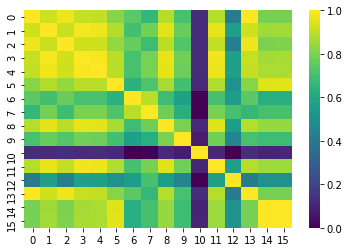

In [30]:

sns.heatmap(corr,cmap = "viridis")

This implies that the test which is failing are generally all those in the top 4 as that is where corrrelation is highest. These are all visual

In [31]:
other_cols = list(combined_copy.columns)
for item in result_cols:
    other_cols.remove(item)
other_cols.append("result")

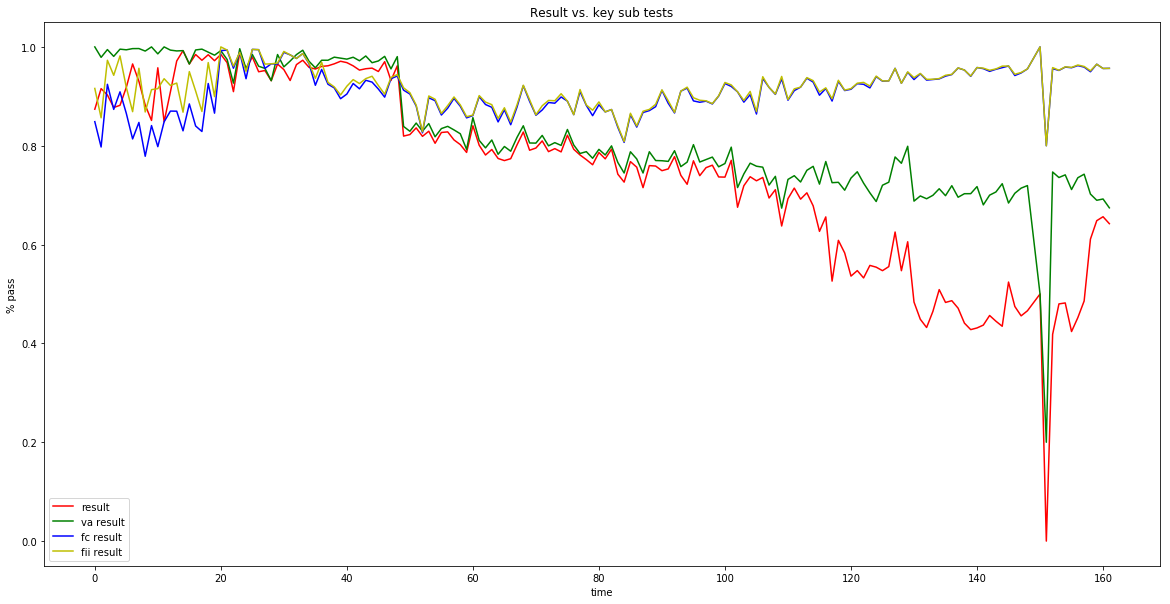

<Figure size 72x72 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
# line 1 points
x1 = combined_copy['time_since_min'].drop_duplicates().sort_values()
y1 = combined_copy[other_cols].groupby('time_since_min')['result'].mean()
# plotting the line 1 points 
plt.plot(x1, y1, label = "result", color = "R")
# line 2 points
x2 = combined_copy['time_since_min'].drop_duplicates().sort_values()
y2 = combined_copy.groupby('time_since_min')['visual_authenticity_result'].mean()
# plotting the line 2 points 
plt.plot(x2, y2, label = "va result",color = "G")
# line 3 points
x3 = combined_copy['time_since_min'].drop_duplicates().sort_values()
y3 = combined_copy.groupby('time_since_min')['face_comparison_result'].mean()
# plotting the line 2 points 
plt.plot(x3, y3, label = "fc result",color = "B")
# line 4 points
x4 = combined_copy['time_since_min'].drop_duplicates().sort_values()
y4 = combined_copy.groupby('time_since_min')['facial_image_integrity_result'].mean()
# plotting the line 2 points 
plt.plot(x4, y4, label = "fii result",color = "Y")
plt.xlabel('time')
# Set the y axis label of the current axis.
plt.ylabel('% pass')
# Set a title of the current axes.
plt.title('Result vs. key sub tests')
# show a legend on the plot
plt.legend()
plt.figure(figsize=(1,1))
# Display a figure.
plt.show()

We can now see that there was an anomaly around time since min = 150 and 151

In [34]:
combined_copy['anomaly'] = combined_copy['time_since_min'].apply(lambda x: 1 if x == 150 | x == 151 else 0)

In [35]:
combined_copy.groupby('anomaly').mean().iloc[0,:]

result                                  0.657089
visual_authenticity_result              0.769969
image_integrity_result                  0.689601
face_detection_result                   0.788531
image_quality_result                    0.806265
supported_document_result               0.983308
conclusive_document_quality_result      0.405598
colour_picture_result                   0.508006
data_validation_result                  0.741673
data_consistency_result                 0.486026
data_comparison_result                  0.011888
police_record_result                    0.761106
compromised_document_result             0.253985
sub_result                              0.657089
face_comparison_result                  0.916376
facial_image_integrity_result           0.919973
time_since_min                        104.001208
Name: 0, dtype: float64

In [36]:
labels = result_cols
men_means = np.round(list(combined_copy[result_cols+['anomaly']].groupby('anomaly').mean().iloc[0,:]),2)
women_means = np.round(list(combined_copy[result_cols+['anomaly']].groupby('anomaly').mean().iloc[1,:]),2)

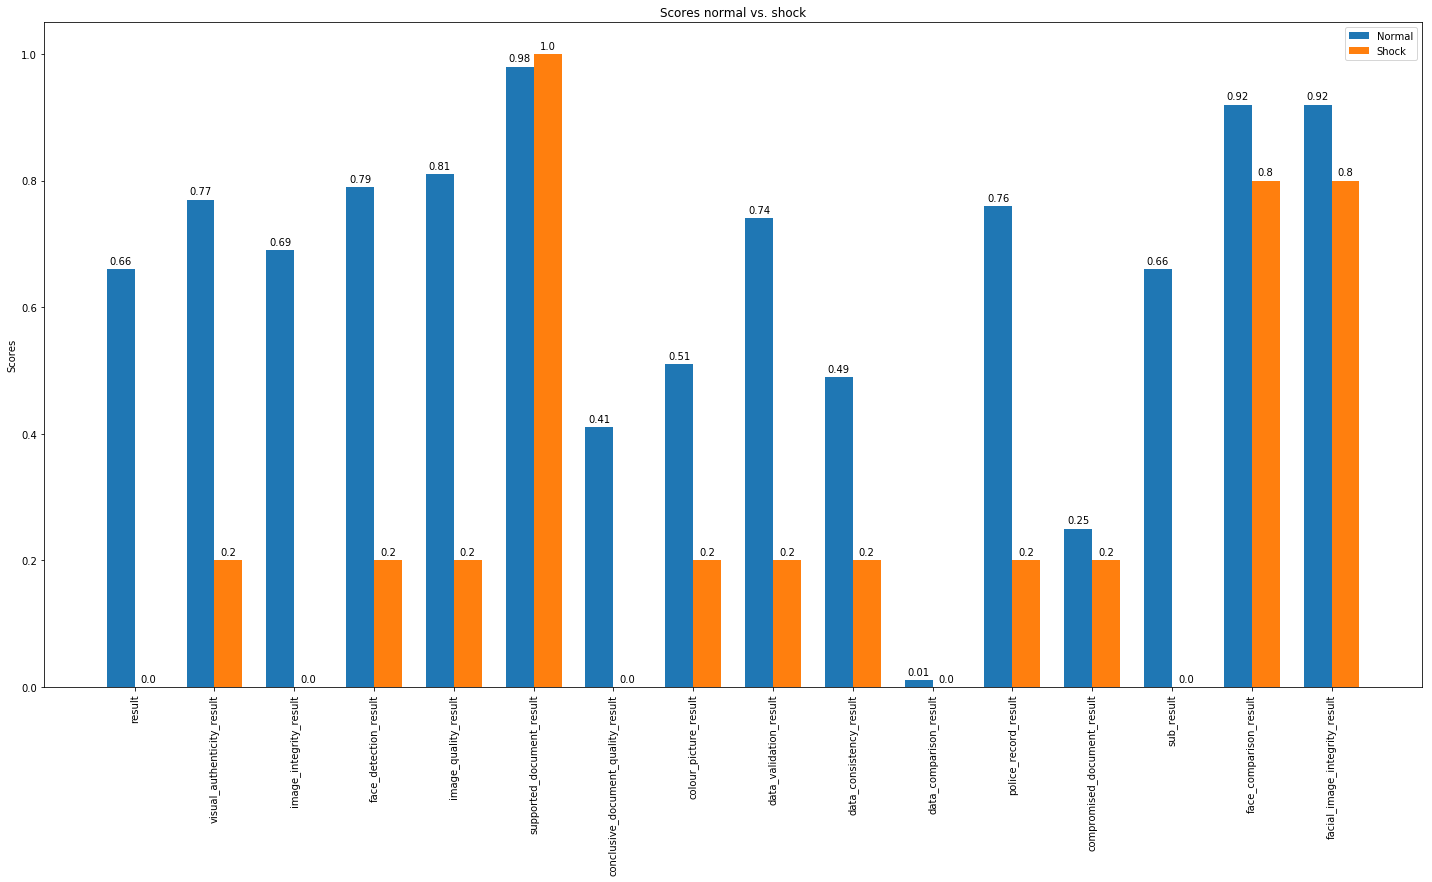

In [38]:


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Normal')
rects2 = ax.bar(x + width/2, women_means, width, label='Shock')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores normal vs. shock')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

## Diving into demographic data

In [40]:
demographic_data = ['date_of_expiry','document_type','document_version','gender','issuing_country','issuing_date','issuing_state','nationality',
                   ]

#combined_copy.head(2)

In [41]:
combined_copy.groupby('document_type')['result'].mean()

document_type
birth_certificate         1.000000
driving_licence           0.838032
national_identity_card    0.864242
passport                  0.772392
residence_permit          0.864230
tax_id                    1.000000
voter_id                  1.000000
work_permit               0.947368
Name: result, dtype: float64

In [42]:
combined_copy.groupby('document_type')['result'].count()

document_type
birth_certificate             2
driving_licence           65013
national_identity_card    68423
passport                  57946
residence_permit           4213
tax_id                       12
voter_id                     13
work_permit                  19
Name: result, dtype: int64

In [44]:
#print(combined_copy.groupby('result')['issuing_data_is_nan'].mean())
combined_copy['issuing_data_is_nan'] = combined_copy['issuing_date'].apply(lambda x: 1 if pd.isna(x) else 0)
demographic_data.append('issuing_data_is_nan')

In [46]:
#print(combined_copy.groupby('result')['issuing_state_is_nan'].mean())
combined_copy['issuing_state_is_nan'] = combined_copy['issuing_state'].apply(lambda x: 1 if pd.isna(x) else 0)
demographic_data.append('issuing_state_is_nan')

In [47]:
combined_copy['nationality_is_country'] = combined_copy['nationality'] == combined_copy['issuing_country']
combined_copy['nationality_is_country'] = combined_copy['nationality_is_country'].apply(lambda x: 1 if x == True else 0)
demographic_data.append('nationality_is_country')

In [48]:
print(combined_copy.groupby('result')['nationality_is_country'].mean())

result
0    0.220853
1    0.492697
Name: nationality_is_country, dtype: float64


Let's see if making boolean types for all the dummies is worth it. Ignoring time:

In [49]:
for item in demographic_data:
    print(combined_copy.groupby(item)['result'].mean())

date_of_expiry
1929-10-15    0.0
1972-09-17    0.0
1972-12-06    0.0
1983-01-13    0.0
1983-11-19    1.0
1984-02-27    0.0
1990-11-25    1.0
1999-01-01    0.0
1999-03-30    1.0
1999-12-31    0.0
2000-06-28    0.0
2001-05-31    0.0
2001-12-19    0.0
2002-08-02    0.0
2003-01-12    0.0
2003-01-14    0.0
2003-10-02    0.0
2004-04-02    1.0
2004-08-17    0.0
2004-11-12    1.0
2005-03-16    0.0
2005-08-05    0.0
2005-11-15    0.0
2006-01-22    0.0
2006-04-01    0.0
2006-06-14    1.0
2006-06-20    0.0
2006-07-17    0.0
2007-01-17    0.0
2007-05-12    0.0
             ... 
2063-11-22    1.0
2064-02-17    1.0
2064-03-29    1.0
2064-08-23    1.0
2064-09-20    1.0
2065-08-16    1.0
2066-11-11    0.0
2067-03-07    1.0
2067-10-05    0.0
2070-01-02    1.0
2070-08-28    1.0
2071-03-01    1.0
2071-11-11    1.0
2072-10-29    1.0
2072-12-10    1.0
2074-03-30    1.0
2074-04-19    0.0
2074-12-23    1.0
2075-02-04    0.0
2076-01-01    1.0
2076-02-24    1.0
2076-05-03    1.0
2076-08-01    1.0
2076-10-01   

From this, it seems that document_type, issuing country, nationality (although lots of wrong entries here) and nationality is country make a difference. Below confirms we have a sufficient amount of both types of "nationality is country" to try and gauge result

In [50]:
combined_copy.groupby('result')['nationality_is_country'].count()

result
0     84581
1    162065
Name: nationality_is_country, dtype: int64

Edit issuing country to get a good list of booleans

In [51]:
issuing_country_bools = list(combined_copy.groupby('issuing_country')['issuing_country'].count().sort_values(ascending = False).head(7).index)

In [52]:
combined_copy['issuing_country_edit'] = combined_copy['issuing_country'].apply(lambda x: x if x in issuing_country_bools else "other")

Edit nationality to get a good list of nationalities

In [53]:
nationality_bools = list(combined_copy.groupby('nationality')['nationality'].count().sort_values(ascending = False).head(7).index)
combined_copy['nationality_edit'] = combined_copy['nationality'].apply(lambda x: x if x in nationality_bools else "other")

Remove bad gender results and edit gender

In [54]:
combined_copy = combined_copy[combined_copy['gender'] !=8]
combined_copy.loc[combined_copy['gender'] == "MALE",'gender'] = "Male"
combined_copy.loc[combined_copy['gender'] == "FEMALE",'gender'] = "Female"

In [55]:
combined_copy.loc[combined_copy['gender'].isna(),'gender'] = combined_copy['gender'].mode()[0]

Add in date of expiry

In [56]:
combined_copy.loc[combined_copy['date_of_expiry'].isna(),'date_of_expiry'] = combined_copy['date_of_expiry'].mode()[0]

In [57]:
combined_copy = combined_copy[combined_copy['date_of_expiry'] != "2027-02-30"]

In [58]:
combined_copy['date_of_expiry_edit'] = combined_copy['date_of_expiry'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d') )
combined_copy['date_of_expiry_edit'] = (combined_copy['date_of_expiry_edit'] - combined_copy['date_of_expiry_edit'].min())
combined_copy['date_of_expiry_edit'] = round(combined_copy['date_of_expiry_edit'].apply(lambda x: x.days)/30,0)

## Estimating ie result

In [59]:

def make_bool(df,cols):
    new_df = df.copy(deep = True) ## do not edit in place
    out_list = []
    for item in cols:
        vals = list(new_df[item].dropna().drop_duplicates())
       
        vals.sort()
        for i,j in enumerate(vals):
            if i==0:
                print("Skipping")
            else:
            #print(i)
            #print(j)
                new_df[item+str("_is_")+str(j)+str("_edit")] = 0
                new_df.at[(new_df[item] ==j) ,item+str("_is_")+str(j)+str("_edit")] = 1 ## Need to create a new column to avoid overwriting
            #new_df[item] = new_df[item+str("_edit")] ## set new column to old column
                out_list.append(item+str("_is_")+str(j)+str("_edit"))
        new_df.drop(labels = (item),axis = 1, inplace = True)
    return new_df,out_list


## Therefore this is added as a new variable instead of cabin number. Looking at cabin number seems to provide no indication
## of anything really

In [60]:
[combined_copy_new,out_list]=make_bool(combined_copy,['document_type','nationality_edit','issuing_country_edit','gender'])

Skipping
Skipping
Skipping
Skipping


In [61]:
model_data = combined_copy_new[out_list+['issuing_state_is_nan','issuing_data_is_nan','nationality_is_country','date_of_expiry_edit','time_since_min','result']]

In [62]:
model_data = model_data.dropna()
model_data.reset_index(inplace = True, drop = True)

In [63]:
Y = model_data['result']
X = model_data[out_list+['issuing_state_is_nan','issuing_data_is_nan','nationality_is_country','date_of_expiry_edit','time_since_min',]]

In [64]:
X_train = X.iloc[round(len(X)/2):,:]
Y_train = Y.iloc[round(len(Y)/2):]
from sklearn.linear_model import LogisticRegression
#logit_data = all_data[all_data['data_type'] == "train"]
Y_train = np.array(Y_train)
X_train=np.array(X_train)
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
clf.predict(X_train)

clf.predict_proba(X_train)

clf.score(X, Y)
X_test = X.iloc[:round(len(X)/2),:]
Y_test = Y.iloc[:round(len(Y)/2)]
y_hat = clf.predict(X_test)
y_act = np.reshape(Y_test,newshape = (len(Y_test),))
accuracy = 1-(np.abs(y_hat - y_act).sum()/len(y_hat))

C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [65]:
y_hat = clf.predict(X_test)
y_act = np.reshape(Y_test,newshape = (len(Y_test),))

In [66]:
accuracy = 1-(np.abs(y_hat - y_act).sum()/len(y_hat))

In [67]:
accuracy

0.7953568706313553

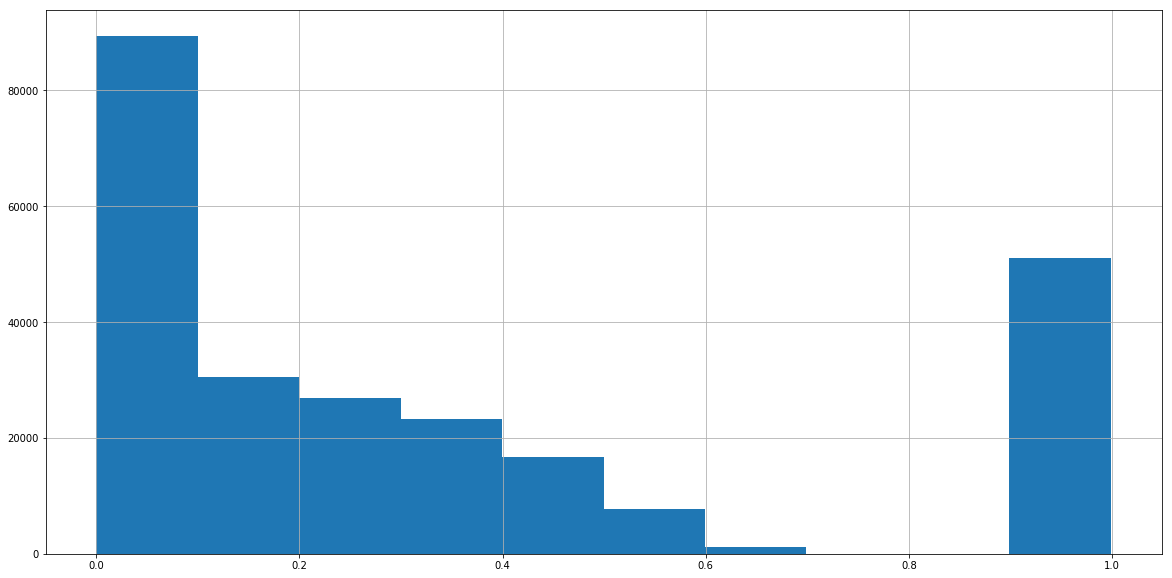

In [68]:
pd.DataFrame(clf.predict_proba(X))[0].hist()

In [69]:
coefficients = pd.DataFrame(clf.coef_.T).copy(deep = True)
indep_vars = out_list+['issuing_state_is_nan','issuing_data_is_nan','nationality_is_country']
coefficients['labels'] = (out_list+['issuing_state_is_nan','issuing_data_is_nan','nationality_is_country','date_of_expiry_edit','time_since_min',])
coefficients['abs_coef_size'] = coefficients[0].apply(lambda x: np.abs(x))

In [70]:
combined_copy['nationality_is_country'].mean()
coefficients[coefficients['labels'] == 'nationality_is_country']

,0,labels,abs_coef_size
25,0.706974,nationality_is_country,0.706974


In [71]:
coefficients[coefficients['labels'] == 'issuing_data_is_nan']

,0,labels,abs_coef_size
24,-0.520712,issuing_data_is_nan,0.520712


In [72]:
np.abs(y_hat - y_act).sum()

25237

In [73]:
#standard errors
from sklearn import linear_model
logit = linear_model.LogisticRegression()
resLogit = logit.fit(X_train, Y_train)
predProbs = resLogit.predict_proba(X_train)
X_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
V = (np.product(predProbs, axis=1))
V = np.reshape(V,newshape=(len(V),1))
covLogit = np.linalg.inv((X_design*V).T@X_design)
# Standard errors
standard_errors = np.sqrt(np.diag(covLogit))


C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [74]:

coefficients['std'] = standard_errors[1:len(standard_errors)]
coefficients['significant'] = (coefficients['abs_coef_size'] - 1.96*coefficients['std'])>0

In [75]:
coefficients[coefficients['significant'] == True]

,0,labels,abs_coef_size,std,significant
0,6.312452,document_type_is_driving_licence_edit,6.312452,0.077993,True
1,6.321358,document_type_is_national_identity_card_edit,6.321358,0.070346,True
2,5.702053,document_type_is_passport_edit,5.702053,0.080817,True
3,6.885265,document_type_is_residence_permit_edit,6.885265,0.097577,True
8,0.573245,nationality_edit_is_GBR_edit,0.573245,0.118833,True
10,-0.331193,nationality_edit_is_LTU_edit,0.331193,0.136981,True
13,0.315258,nationality_edit_is_other_edit,0.315258,0.113305,True
15,-0.569599,issuing_country_edit_is_GBR_edit,0.569599,0.099910,True
17,0.473328,issuing_country_edit_is_LTU_edit,0.473328,0.117985,True
18,0.300502,issuing_country_edit_is_POL_edit,0.300502,0.129251,True


We can also try this with less variables, including only those that were significance in the first pass logit

In [76]:
new_list = []
for item in list(coefficients[coefficients['significant'] == True]['labels']):
    new_list.append(item)

Y = model_data['result']
X = model_data[new_list]

In [77]:
X_train = X.iloc[round(len(X)/2):,:]
Y_train = Y.iloc[round(len(Y)/2):]
from sklearn.linear_model import LogisticRegression
#logit_data = all_data[all_data['data_type'] == "train"]
Y_train = np.array(Y_train)
X_train=np.array(X_train)
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
clf.predict(X_train)

clf.predict_proba(X_train)

clf.score(X, Y)
X_test = X.iloc[:round(len(X)/2),:]
Y_test = Y.iloc[:round(len(Y)/2)]
y_hat = clf.predict(X_test)
y_act = np.reshape(Y_test,newshape = (len(Y_test),))
accuracy = 1-(np.abs(y_hat - y_act).sum()/len(y_hat))

C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
#standard errors
from sklearn import linear_model
logit = linear_model.LogisticRegression()
resLogit = logit.fit(X_train, Y_train)
predProbs = resLogit.predict_proba(X_train)
X_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
V = (np.product(predProbs, axis=1))
V = np.reshape(V,newshape=(len(V),1))
covLogit = np.linalg.inv((X_design*V).T@X_design)
# Standard errors
standard_errors = np.sqrt(np.diag(covLogit))


C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [79]:
coefficients = pd.DataFrame(clf.coef_.T).copy(deep = True)

coefficients['labels'] = new_list#(out_list+['issuing_state_is_nan','issuing_data_is_nan','nationality_is_country','date_of_expiry_edit','time_since_min',])
coefficients['abs_coef_size'] = coefficients[0].apply(lambda x: np.abs(x))

coefficients['std'] = standard_errors[1:len(standard_errors)]
coefficients['significant'] = (coefficients['abs_coef_size'] - 1.96*coefficients['std'])>0

In [80]:
coefficients

,0,labels,abs_coef_size,std,significant
0,7.359581,document_type_is_driving_licence_edit,7.359581,0.095583,True
1,7.569622,document_type_is_national_identity_card_edit,7.569622,0.092433,True
2,7.021185,document_type_is_passport_edit,7.021185,0.098147,True
3,8.360580,document_type_is_residence_permit_edit,8.360580,0.120201,True
4,0.181951,nationality_edit_is_GBR_edit,0.181951,0.062303,True
5,-0.142344,nationality_edit_is_LTU_edit,0.142344,0.095670,False
6,-0.073954,nationality_edit_is_other_edit,0.073954,0.058471,False
7,-0.235741,issuing_country_edit_is_GBR_edit,0.235741,0.047573,True
8,0.531828,issuing_country_edit_is_LTU_edit,0.531828,0.075888,True
9,0.214951,issuing_country_edit_is_POL_edit,0.214951,0.052097,True


In [81]:
accuracy

0.7963623684338561

## Detecting Fraud

In [127]:
# file path redacted #

In [83]:
fraudsters['user_id'].nunique() # number of unique fraudsters

300

In [84]:
transactions = transactions.copy(deep = True)
combined = transactions.merge(users, left_on = "USER_ID",right_on = "ID")

In [85]:
combined['USER_ID'].nunique()

8021

In [86]:
fraudsters['is_fraud'] = 1

In [87]:
combined = combined.merge(fraudsters,how ="left",left_on ="USER_ID", right_on = "user_id")

In [88]:
combined['is_fraud'] = combined['is_fraud'].apply(lambda x: 0 if np.isnan(x) else 1)

In [89]:
combined.drop(['STATE_x','CREATED_DATE_x'],axis =1,inplace = True)
combined.drop(['ID_x','ID_y'],axis =1,inplace = True)

In [125]:
# combined.groupby('is_fraud').mean() redacted

In [126]:
# combined.groupby('is_fraud').count() redacted

In [92]:
###Types of transaction by user - LOOKS LIKE WE NEED IS NOK AND IS PLN AND IS EUR; MAYBE CONSIDER REMOVING NON RELEVANT FRAUDS
combined[["CURRENCY", "is_fraud"]].groupby(['is_fraud','CURRENCY'])["CURRENCY"].count()/combined[["CURRENCY", "is_fraud",'USER_ID']].groupby(['is_fraud','CURRENCY'])["USER_ID"].nunique()

is_fraud  CURRENCY
0         AED          15.981132
          AUD          24.823529
          BTC           4.242424
          CAD          20.900000
          CHF          23.319838
          CZK          13.327434
          DKK          23.763889
          ETH           4.377778
          EUR          53.764155
          GBP          73.892517
          HKD          17.142857
          HUF          19.026316
          ILS          15.818182
          INR           7.961538
          JPY          18.794872
          LTC           3.425000
          MAD           4.600000
          NOK          41.450000
          NZD          27.576923
          PLN          32.938806
          QAR           4.666667
          RON          32.536313
          SEK          21.337838
          SGD          15.218750
          THB          10.000000
          TRY           9.657143
          USD          21.932168
          XRP           2.714286
          ZAR          26.186047
1         BTC           

In [93]:
###Types of transaction by user - LOOKS LIKE WE NEED IS CARD PAYMENT AND IS P2P
combined[["TYPE", "is_fraud"]].groupby(['is_fraud','TYPE'])["TYPE"].count()/combined[["TYPE", "is_fraud",'USER_ID']].groupby(['is_fraud','TYPE'])["USER_ID"].nunique()

is_fraud  TYPE         
0         ATM              12.126950
          BANK_TRANSFER     5.328962
          CARD_PAYMENT     77.176904
          P2P              21.111027
          TOPUP            17.249699
1         ATM              13.076023
          BANK_TRANSFER     5.829384
          CARD_PAYMENT     30.990950
          P2P               5.891892
          TOPUP            12.682274
dtype: float64

In [94]:
###States by user - all frauds are locked
combined[["STATE_y", "is_fraud"]].groupby(['is_fraud','STATE_y'])["STATE_y"].count()/combined[["STATE_y", "is_fraud",'USER_ID']].groupby(['is_fraud','STATE_y'])["USER_ID"].nunique()

is_fraud  STATE_y
0         ACTIVE     87.297073
1         LOCKED     48.638796
dtype: float64

Thesis: fraudulent transactions look similar. We should try to find similar transactions based on feature selection.

In [96]:
## fraudulent transactions:
#combined_f = combined[combined['is_fraud'] == 1]
filter_list = ['CURRENCY','MERCHANT_COUNTRY','ENTRY_METHOD','TYPE','SOURCE','COUNTRY','PHONE_COUNTRY','HAS_EMAIL']
combined_filtered = combined.copy(deep = True)
for item in filter_list:
    print("The number of possible non frauds is: " + str(combined_filtered[combined_filtered['is_fraud']==0]['USER_ID'].nunique()))
    cols = list(combined_filtered[item].drop_duplicates())
    combined_filtered['rider'] = combined_filtered[item].apply(lambda x: 1 if x in cols else 0 )
    combined_filtered = combined_filtered[combined_filtered['rider'] == 1]
    
    

The number of possible non frauds is: 7722
The number of possible non frauds is: 7722
The number of possible non frauds is: 7722
The number of possible non frauds is: 7722
The number of possible non frauds is: 7722
The number of possible non frauds is: 7722
The number of possible non frauds is: 7722
The number of possible non frauds is: 7722


In [97]:
combined_filtered.drop('rider',axis =1,inplace = True)

In [98]:
len(combined_filtered)

688651

In [99]:
len(combined)

688651

In [100]:
combined_filtered.groupby('is_fraud')['USER_ID'].nunique()

is_fraud
0    7722
1     299
Name: USER_ID, dtype: int64

In [101]:
###Failed sign in attempts by user - this will be helpful
combined_filtered[["FAILED_SIGN_IN_ATTEMPTS", "is_fraud"]].groupby(['is_fraud','FAILED_SIGN_IN_ATTEMPTS'])["FAILED_SIGN_IN_ATTEMPTS"].sum()/combined_filtered[["FAILED_SIGN_IN_ATTEMPTS", "is_fraud",'USER_ID']].groupby(['is_fraud','FAILED_SIGN_IN_ATTEMPTS'])["USER_ID"].nunique()

is_fraud  FAILED_SIGN_IN_ATTEMPTS
0         0                            0.000000
          1                           76.043478
          2                          196.352941
          3                          143.000000
          6                          480.000000
1         0                            0.000000
          1                           38.000000
          2                           46.000000
dtype: float64

In [102]:
###transaction value by user - LOOKS LIKE ALL ARE GOOD FOR DUMMIES
combined_filtered[["CURRENCY", "is_fraud"]].groupby(['is_fraud','CURRENCY'])["CURRENCY"].count()/combined_filtered[["CURRENCY", "is_fraud",'USER_ID']].groupby(['is_fraud','CURRENCY'])["USER_ID"].nunique()

is_fraud  CURRENCY
0         AED          15.981132
          AUD          24.823529
          BTC           4.242424
          CAD          20.900000
          CHF          23.319838
          CZK          13.327434
          DKK          23.763889
          ETH           4.377778
          EUR          53.764155
          GBP          73.892517
          HKD          17.142857
          HUF          19.026316
          ILS          15.818182
          INR           7.961538
          JPY          18.794872
          LTC           3.425000
          MAD           4.600000
          NOK          41.450000
          NZD          27.576923
          PLN          32.938806
          QAR           4.666667
          RON          32.536313
          SEK          21.337838
          SGD          15.218750
          THB          10.000000
          TRY           9.657143
          USD          21.932168
          XRP           2.714286
          ZAR          26.186047
1         BTC           

In [103]:
###has email - looks as if pretty much all fraudulent transactions have an email
combined_filtered[["HAS_EMAIL", "is_fraud",'USER_ID']].groupby(['is_fraud','HAS_EMAIL'])["USER_ID"].nunique()

is_fraud  HAS_EMAIL
0         0             321
          1            7401
1         0               1
          1             298
Name: USER_ID, dtype: int64

In [104]:
# number of unique merchant countries will also work in a decision tree
print((combined_filtered.groupby(['is_fraud','USER_ID'])['MERCHANT_COUNTRY'].nunique())[0].max())
print((combined_filtered.groupby(['is_fraud','USER_ID'])['MERCHANT_COUNTRY'].nunique())[1].max())

47
18


In [105]:
unique_mcs = pd.DataFrame(combined_filtered[['USER_ID','MERCHANT_COUNTRY']].groupby('USER_ID')['MERCHANT_COUNTRY'].nunique())
unique_mcs.rename(columns = {'MERCHANT_COUNTRY':'n_unique_mcs'},inplace= True)
combined_filtered=combined_filtered.merge(unique_mcs,how = "left" , left_on = "USER_ID",right_on = "USER_ID")

In [106]:
###merchant_category by user - seems very distinct so we should add dummies here too.
(combined_filtered[["MERCHANT_CATEGORY", "is_fraud"]].groupby(['is_fraud','MERCHANT_CATEGORY'])["MERCHANT_CATEGORY"].count()/combined_filtered[["MERCHANT_CATEGORY", "is_fraud",'USER_ID']].groupby(['is_fraud','MERCHANT_CATEGORY'])["USER_ID"].nunique())[0]

MERCHANT_CATEGORY
accounting                      2.537313
administrative_area_level_1     1.920000
administrative_area_level_2     1.615385
administrative_area_level_3     2.866667
administrative_area_level_4     1.000000
airport                         2.398014
amusement_park                  2.309237
aquarium                        1.961538
archipelago                     1.500000
art_gallery                     1.378378
atm                             4.631155
bakery                          2.487692
bank                            3.979893
bar                             6.601942
beauty_salon                    1.744526
bicycle_store                   2.771277
book_store                      2.240453
bowling_alley                   1.764706
bus_station                     1.870662
cafe                            6.225560
campground                      2.291139
car_dealer                      1.907692
car_rental                      2.502732
car_repair                      1.55652

In [107]:
###number_of_transactions
(combined_filtered[[ "is_fraud",'USER_ID']].groupby(['is_fraud'])["USER_ID"].count()/combined_filtered[[ "is_fraud",'USER_ID']].groupby(['is_fraud'])["USER_ID"].nunique())

is_fraud
0    87.297073
1    48.638796
Name: USER_ID, dtype: float64

In [108]:
num_trs = pd.DataFrame(combined_filtered[['USER_ID']].groupby('USER_ID')['USER_ID'].count())
num_trs.rename(columns = {'USER_ID':'n_unique_trs'},inplace= True)
combined_filtered=combined_filtered.merge(num_trs,how = "left" , left_on = "USER_ID",right_on = "USER_ID")

In [109]:
[combined_filtered,dummy_list] = make_bool(combined_filtered,['MERCHANT_CATEGORY','CURRENCY'])

Skipping
Skipping


In [110]:
x_vars = dummy_list +['HAS_EMAIL','FAILED_SIGN_IN_ATTEMPTS','n_unique_trs','n_unique_mcs']
y_vars = ['is_fraud']

In [111]:
model_data = combined_filtered[x_vars+y_vars]

In [112]:
model_data_fraud = model_data[model_data['is_fraud']==1]
model_data_non_fraud = model_data[model_data['is_fraud']==0]

In [113]:
from sklearn import model_selection 
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier 

X = np.array(model_data[x_vars])
Y = np.array(model_data[y_vars])
#Y = np.reshape(Y,newshape = (len(Y),1))
  
seed = 8
kfold = model_selection.KFold(n_splits = 10, 
                       random_state = seed) 
  
# initialize the base classifier 
base_cls = DecisionTreeClassifier(min_samples_split = 30) 
  
# no. of base classifier 
num_trees = 10
  
# bagging classifier 
model = BaggingClassifier(base_estimator = base_cls, 
                          n_estimators = num_trees, 
                          random_state = seed,
                         max_samples = round(len(model_data)/1.3),
                         bootstrap = True)
fit = model.fit(X,Y)
  
results = model_selection.cross_val_score(model, X, Y, cv = kfold) 
print("accuracy :") 
print(results.mean()) 

C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

accuracy :
0.966084385046065


In [114]:
predictions_train = ((fit.predict(X)))
output = pd.DataFrame()
output['y_hat'] = predictions_train
output['y'] = Y
output['true_positives'] = None
output.at[(output['y'] ==1) & (output['y_hat']==1),'true_positives'] = 1
output['true_negatives'] = None
output.at[(output['y'] ==0) & (output['y_hat']==0),'true_negatives'] = 1
output['false_positives'] = None
output.at[(output['y'] ==0) & (output['y_hat']==1),'false_positives'] = 1
output['false_negatives'] = None
output.at[(output['y'] ==1) & (output['y_hat']==0),'false_negatives'] = 1

In [115]:
output.sum()

y_hat               11320.0
y                   14543.0
true_positives      10200.0
true_negatives     672988.0
false_positives      1120.0
false_negatives      4343.0
dtype: float64

In [116]:
final_output = combined_filtered.copy(deep = True)

In [117]:
final_output['y_pred'] = output['y_hat']

In [118]:
fraudulent_users = list(final_output[final_output['y_pred'] == 1]['USER_ID'].drop_duplicates())

In [119]:
given_fraudulent_users = list(fraudsters['user_id'].drop_duplicates())

In [120]:
final_fraudulent_users = fraudulent_users.copy()
for item in fraudulent_users:
    if item in given_fraudulent_users:
        final_fraudulent_users.remove(item)

In [121]:
len(final_fraudulent_users) # number of predicted frauds

144